## Importing libraries

In [37]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem.MolStandardize import rdMolStandardize
from chembl_webresource_client.new_client import new_client
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt

In [38]:
df_main=pd.read_excel (r'C:\Users\DELL\Desktop\Dissertation\Data/prep_data/final_rdrp_data_PIC50.xlsx')

In [39]:
df_main=pd.DataFrame(df_main)

In [40]:
df_main

,CHEMBL ID,Smiles,IC50,PIC50
0,CHEMBL1077125,CC(C)CCn1c2ccc(cc2c(c(c1=O)C3=NS(=O)(=O)c4cc(c...,5.0,8.30
1,CHEMBL1077290,c1cc(ccc1/C=C/C(=O)O)NC(=O)C2(CCC2)NC(=O)c3ccc...,50.0,7.30
2,CHEMBL1077321,c1ccnc(c1)c2nc3cc(ccc3n2C4CCCCC4)C(=O)N[C@@H](...,140.0,6.85
3,CHEMBL1077331,c1cc2c(cc1C(=O)c3nc4cc(ccc4n3C5CCCCC5)C(=O)N[C...,380.0,6.42
4,CHEMBL1077335,c1ccnc(c1)c2nc3cc(ccc3n2C4CCCCC4)C(=O)NC5(CCCC...,30000.0,4.52
...,...,...,...,...
2665,CHEMBL501849,COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=...,10.0,8.00
2666,CHEMBL490672,CCc1cc(CC[C@]2(C3CCCC3)CC(O)=C(Cc3nc4nc(C)cc(C...,30000.0,4.52
2667,CHEMBL449782,COc1ccc2cc1Oc1ccc(cc1)C[C@H]1c3c(cc4c(c3Oc3cc5...,231.0,6.64
2668,CHEMBL2347474,CS(=O)(=O)NC(=O)c1c(c2c(n1Cc3ccccc3Cl)ccc4c2oc...,3.0,8.52


## Data pre-processing of the bioactivity data

### Labeling compounds as either being active, inactive or intermediate
The bioactivity data is in the IC50 unit. Compounds having values of less than 1000 nM will be considered to be **active** while those greater than 10,000 nM will be considered to be **inactive**. As for those values in between 1,000 and 10,000 nM will be referred to as **intermediate**. 

In [41]:
df_main['PIC50'] = df_main['PIC50'].astype(float)
df_main['bioactivity_class'] = df_main['PIC50'].map(lambda x : 'active' if x >=6.5 else ('inactive' if x<=6.5 else 'intermediate'))

In [42]:
df_main['bioactivity_class'].value_counts()

active      1539
inactive    1131
Name: bioactivity_class, dtype: int64

In [43]:
'''
function to estimate molecule Lipinski descriptors

'''

def lipinski(smiles, verbose=False):
    moldata= []
    problematic_smiles=[]
    for i,elem in enumerate(smiles):
        try:
            mol=Chem.MolFromSmiles(elem) 
            mol = rdMolStandardize.Cleanup(mol)
            moldata.append(mol)  
        except:
            problematic_smiles.append(i)
            pass
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return  descriptors,problematic_smiles

In [44]:
df_lipinski, problematic_smiles = lipinski(df_main.Smiles)

In [45]:
df_lipinski.head(10).style.background_gradient()

,MW,LogP,NumHDonors,NumHAcceptors
0,468.510000,3.519380,2.000000,7.000000
1,552.631000,6.190500,3.000000,6.000000
2,562.699000,6.960700,3.000000,7.000000
3,724.818000,8.109900,4.000000,9.000000
4,577.685000,6.382600,3.000000,6.000000
5,238.224000,0.902200,3.000000,5.000000
6,486.487000,2.565800,5.000000,8.000000
7,374.356000,-0.016700,5.000000,8.000000
8,528.634000,5.882600,4.000000,6.000000
9,567.740000,7.627200,3.000000,7.000000


In [46]:
df_main = pd.concat([df_main,df_lipinski], axis=1)

In [47]:
df_main

,CHEMBL ID,Smiles,IC50,PIC50,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL1077125,CC(C)CCn1c2ccc(cc2c(c(c1=O)C3=NS(=O)(=O)c4cc(c...,5.0,8.30,active,468.510,3.51938,2.0,7.0
1,CHEMBL1077290,c1cc(ccc1/C=C/C(=O)O)NC(=O)C2(CCC2)NC(=O)c3ccc...,50.0,7.30,active,552.631,6.19050,3.0,6.0
2,CHEMBL1077321,c1ccnc(c1)c2nc3cc(ccc3n2C4CCCCC4)C(=O)N[C@@H](...,140.0,6.85,active,562.699,6.96070,3.0,7.0
3,CHEMBL1077331,c1cc2c(cc1C(=O)c3nc4cc(ccc4n3C5CCCCC5)C(=O)N[C...,380.0,6.42,inactive,724.818,8.10990,4.0,9.0
4,CHEMBL1077335,c1ccnc(c1)c2nc3cc(ccc3n2C4CCCCC4)C(=O)NC5(CCCC...,30000.0,4.52,inactive,577.685,6.38260,3.0,6.0
...,...,...,...,...,...,...,...,...,...
2665,CHEMBL501849,COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=...,10.0,8.00,active,749.956,5.25412,2.0,10.0
2666,CHEMBL490672,CCc1cc(CC[C@]2(C3CCCC3)CC(O)=C(Cc3nc4nc(C)cc(C...,30000.0,4.52,inactive,503.647,5.12424,1.0,8.0
2667,CHEMBL449782,COc1ccc2cc1Oc1ccc(cc1)C[C@H]1c3c(cc4c(c3Oc3cc5...,231.0,6.64,active,606.719,6.87390,0.0,8.0
2668,CHEMBL2347474,CS(=O)(=O)NC(=O)c1c(c2c(n1Cc3ccccc3Cl)ccc4c2oc...,3.0,8.52,active,495.944,4.13390,2.0,6.0


In [48]:
df_main=df_main.drop(columns="PIC50")

### Convert IC50 to pIC50
To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

In [49]:
def pIC50(i):
    molar = i*(10**-9) # Converts nM to M
    pIC50 = -np.log10(molar)
    return pIC50

Point to note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [50]:
df_main.IC50.describe()

count    2.670000e+03
mean     3.198333e+04
std      1.505745e+06
min      2.200000e-02
25%      3.000000e+01
50%      1.700000e+02
75%      1.300000e+03
max      7.780000e+07
Name: IC50, dtype: float64

In [51]:
df=df_main

In [52]:
df

,CHEMBL ID,Smiles,IC50,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL1077125,CC(C)CCn1c2ccc(cc2c(c(c1=O)C3=NS(=O)(=O)c4cc(c...,5.0,active,468.510,3.51938,2.0,7.0
1,CHEMBL1077290,c1cc(ccc1/C=C/C(=O)O)NC(=O)C2(CCC2)NC(=O)c3ccc...,50.0,active,552.631,6.19050,3.0,6.0
2,CHEMBL1077321,c1ccnc(c1)c2nc3cc(ccc3n2C4CCCCC4)C(=O)N[C@@H](...,140.0,active,562.699,6.96070,3.0,7.0
3,CHEMBL1077331,c1cc2c(cc1C(=O)c3nc4cc(ccc4n3C5CCCCC5)C(=O)N[C...,380.0,inactive,724.818,8.10990,4.0,9.0
4,CHEMBL1077335,c1ccnc(c1)c2nc3cc(ccc3n2C4CCCCC4)C(=O)NC5(CCCC...,30000.0,inactive,577.685,6.38260,3.0,6.0
...,...,...,...,...,...,...,...,...
2665,CHEMBL501849,COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=...,10.0,active,749.956,5.25412,2.0,10.0
2666,CHEMBL490672,CCc1cc(CC[C@]2(C3CCCC3)CC(O)=C(Cc3nc4nc(C)cc(C...,30000.0,inactive,503.647,5.12424,1.0,8.0
2667,CHEMBL449782,COc1ccc2cc1Oc1ccc(cc1)C[C@H]1c3c(cc4c(c3Oc3cc5...,231.0,active,606.719,6.87390,0.0,8.0
2668,CHEMBL2347474,CS(=O)(=O)NC(=O)c1c(c2c(n1Cc3ccccc3Cl)ccc4c2oc...,3.0,active,495.944,4.13390,2.0,6.0


In [53]:
df['pIC50'] = df['IC50'].map(pIC50)

### Removing the 'intermediate' bioactivity class
Here, we will be removing the ``intermediate`` class from our data set.

In [54]:
df = df[df['bioactivity_class'] != 'intermediate']

In [55]:
df_main['bioactivity_class'].value_counts()

active      1539
inactive    1131
Name: bioactivity_class, dtype: int64

In [56]:
df

,CHEMBL ID,Smiles,IC50,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL1077125,CC(C)CCn1c2ccc(cc2c(c(c1=O)C3=NS(=O)(=O)c4cc(c...,5.0,active,468.510,3.51938,2.0,7.0,8.301030
1,CHEMBL1077290,c1cc(ccc1/C=C/C(=O)O)NC(=O)C2(CCC2)NC(=O)c3ccc...,50.0,active,552.631,6.19050,3.0,6.0,7.301030
2,CHEMBL1077321,c1ccnc(c1)c2nc3cc(ccc3n2C4CCCCC4)C(=O)N[C@@H](...,140.0,active,562.699,6.96070,3.0,7.0,6.853872
3,CHEMBL1077331,c1cc2c(cc1C(=O)c3nc4cc(ccc4n3C5CCCCC5)C(=O)N[C...,380.0,inactive,724.818,8.10990,4.0,9.0,6.420216
4,CHEMBL1077335,c1ccnc(c1)c2nc3cc(ccc3n2C4CCCCC4)C(=O)NC5(CCCC...,30000.0,inactive,577.685,6.38260,3.0,6.0,4.522879
...,...,...,...,...,...,...,...,...,...
2665,CHEMBL501849,COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=...,10.0,active,749.956,5.25412,2.0,10.0,8.000000
2666,CHEMBL490672,CCc1cc(CC[C@]2(C3CCCC3)CC(O)=C(Cc3nc4nc(C)cc(C...,30000.0,inactive,503.647,5.12424,1.0,8.0,4.522879
2667,CHEMBL449782,COc1ccc2cc1Oc1ccc(cc1)C[C@H]1c3c(cc4c(c3Oc3cc5...,231.0,active,606.719,6.87390,0.0,8.0,6.636388
2668,CHEMBL2347474,CS(=O)(=O)NC(=O)c1c(c2c(n1Cc3ccccc3Cl)ccc4c2oc...,3.0,active,495.944,4.13390,2.0,6.0,8.522879


## Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors

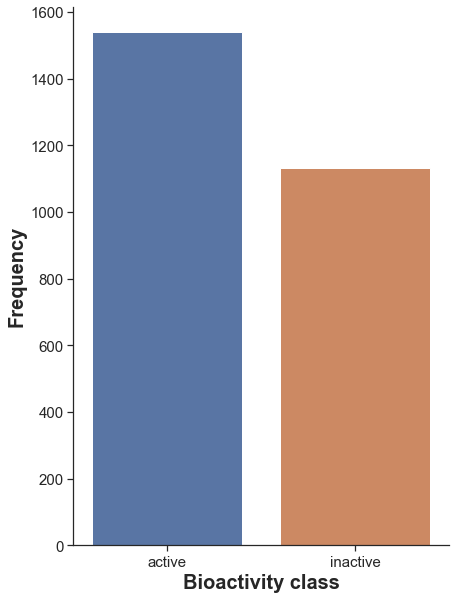

In [57]:
plt.figure(figsize=(6.5, 8.5))

sns.countplot(x='bioactivity_class', data=df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('Frequency', fontsize=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)
sns.set(style='ticks')
sns.despine(top=True)
plt.tight_layout()
plt.savefig('plot_bioactivity_class.png')

### Pairplot of the features

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

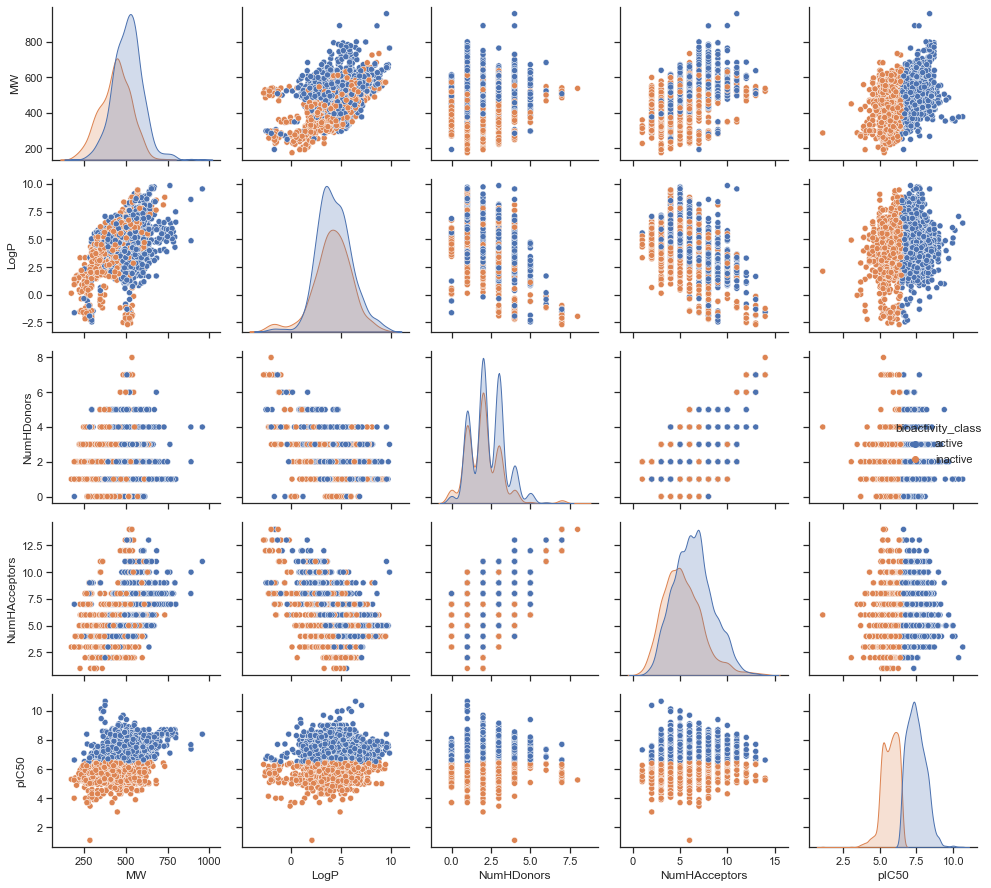

In [58]:
selection = ['bioactivity_class','MW','LogP','NumHDonors','NumHAcceptors','pIC50']
sns.pairplot(df[selection], hue='bioactivity_class')
plt.tight_layout()
plt.savefig('Pairplot.png',dpi=300)

### Boxplot of pIC50

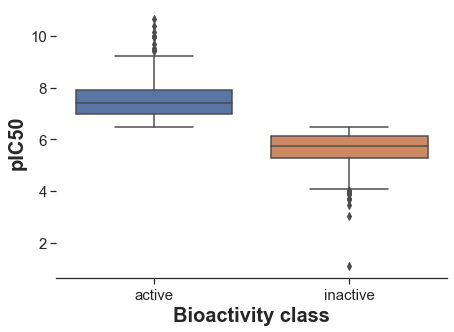

In [59]:
fig = plt.figure(figsize=(7,5))
sns.boxplot(x='bioactivity_class', y='pIC50', data = df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('pIC50', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)
sns.despine(top=True, left=True)
plt.savefig('boxplot_pIC50.png',dpi=300);

### Boxplot of Lipinksi descriptors

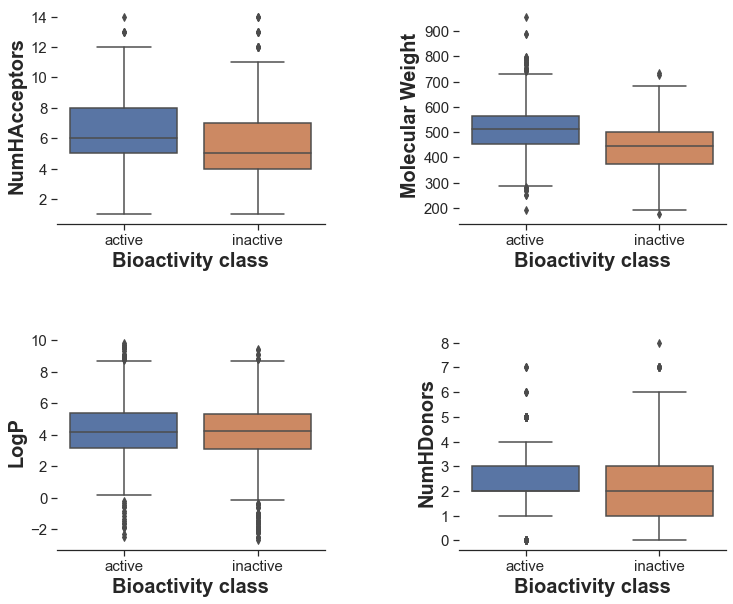

In [60]:
fig = plt.figure(figsize=(12,10))
fig.subplots_adjust(hspace=0.5,wspace=0.5)
fig.add_subplot(2,2,1)
sns.boxplot(x='bioactivity_class', y='NumHAcceptors', data = df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('NumHAcceptors', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)

fig.add_subplot(2,2,2)
sns.boxplot(x='bioactivity_class', y='MW', data = df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('Molecular Weight', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)

fig.add_subplot(2,2,3)
sns.boxplot(x='bioactivity_class', y='LogP', data = df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('LogP', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)

fig.add_subplot(2,2,4)
sns.boxplot(x='bioactivity_class', y='NumHDonors', data = df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('NumHDonors', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)

sns.despine(top=True, left=True)
plt.savefig('boxplot_lipinksi_descriptors.png',dpi=300);

## Statistical analysis | Mann-Whitney U Test

In [61]:
def mannwhitney_(active,inactive, descriptor):
  stat, p = mannwhitneyu(active,inactive)
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [62]:
for feature in selection[1:]: 
    results=mannwhitney_(df[df['bioactivity_class'] != 'inactive'][feature],
                df[df['bioactivity_class'] ==  'inactive'][feature],
                feature)

    display(results)

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,1247418.5,8.125825e-82,0.05,Different distribution (reject H0)


,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,893031.5,0.24825,0.05,Same distribution (fail to reject H0)


,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,1022471.5,7.204232e-16,0.05,Different distribution (reject H0)


,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1138759.5,3.258735e-43,0.05,Different distribution (reject H0)


,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,1740609.0,0.0,0.05,Different distribution (reject H0)


In [63]:
df

,CHEMBL ID,Smiles,IC50,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL1077125,CC(C)CCn1c2ccc(cc2c(c(c1=O)C3=NS(=O)(=O)c4cc(c...,5.0,active,468.510,3.51938,2.0,7.0,8.301030
1,CHEMBL1077290,c1cc(ccc1/C=C/C(=O)O)NC(=O)C2(CCC2)NC(=O)c3ccc...,50.0,active,552.631,6.19050,3.0,6.0,7.301030
2,CHEMBL1077321,c1ccnc(c1)c2nc3cc(ccc3n2C4CCCCC4)C(=O)N[C@@H](...,140.0,active,562.699,6.96070,3.0,7.0,6.853872
3,CHEMBL1077331,c1cc2c(cc1C(=O)c3nc4cc(ccc4n3C5CCCCC5)C(=O)N[C...,380.0,inactive,724.818,8.10990,4.0,9.0,6.420216
4,CHEMBL1077335,c1ccnc(c1)c2nc3cc(ccc3n2C4CCCCC4)C(=O)NC5(CCCC...,30000.0,inactive,577.685,6.38260,3.0,6.0,4.522879
...,...,...,...,...,...,...,...,...,...
2665,CHEMBL501849,COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=...,10.0,active,749.956,5.25412,2.0,10.0,8.000000
2666,CHEMBL490672,CCc1cc(CC[C@]2(C3CCCC3)CC(O)=C(Cc3nc4nc(C)cc(C...,30000.0,inactive,503.647,5.12424,1.0,8.0,4.522879
2667,CHEMBL449782,COc1ccc2cc1Oc1ccc(cc1)C[C@H]1c3c(cc4c(c3Oc3cc5...,231.0,active,606.719,6.87390,0.0,8.0,6.636388
2668,CHEMBL2347474,CS(=O)(=O)NC(=O)c1c(c2c(n1Cc3ccccc3Cl)ccc4c2oc...,3.0,active,495.944,4.13390,2.0,6.0,8.522879


In [64]:
df.to_csv(r'C:\Users\DELL\Desktop\Dissertation\Data/prep_data/feature_selected_data/rdrp-data13.csv')

In [65]:
df['pIC50'].astype(int).value_counts()

7     811
6     765
5     667
8     324
4      64
9      25
3       9
10      4
1       1
Name: pIC50, dtype: int64

## Conclusion

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 5 = Inactives``) were used to define actives and inactives.


All of the 4 Lipinski's descriptors exhibited ***statistically significant difference*** between the **actives** and **inactives**.